데이터 로드 완료: 1,266,865개 행, 24개 컬럼
=== TMDB 영화 데이터 분석 시작 ===

1. 데이터 전처리 중...
   전처리 완료: 213,580개 샘플

2. 기본 탐색적 데이터 분석...


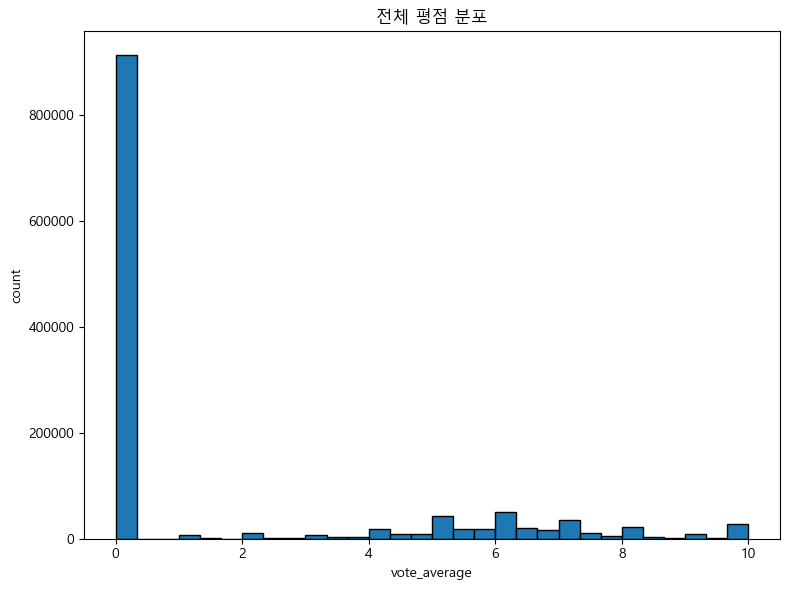

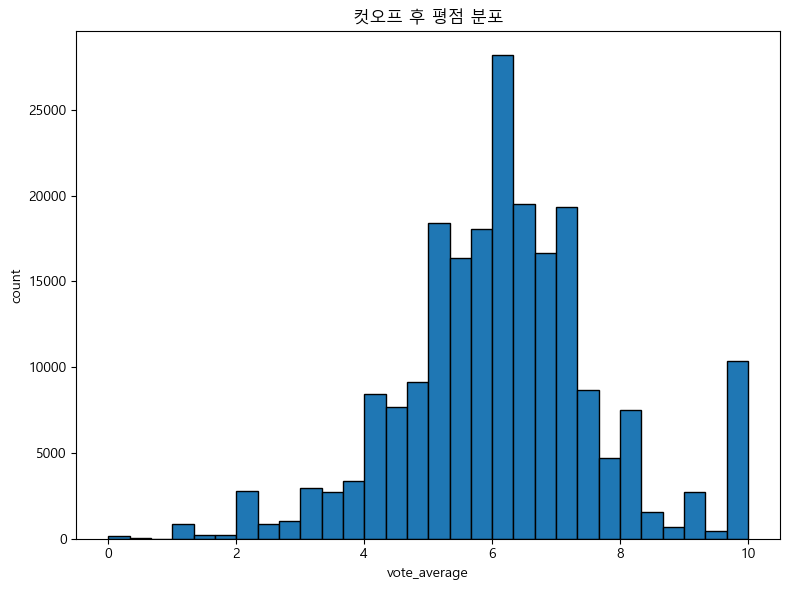

평점 구간별 비율(%):
rating_category
기타     60.42
평범     24.15
성공      4.52
대성공    10.90
Name: count, dtype: float64

3. 장르 및 시대별 분석...
상위 10개 장르:
          genre  percentage_unique
3        Comedy              29.27
16     Thriller              14.43
6         Drama              13.61
5   Documentary              12.76
13      Romance              12.68
0        Action              12.02
10       Horror              11.86
4         Crime               7.89
2     Animation               7.01
15     TV Movie               6.77


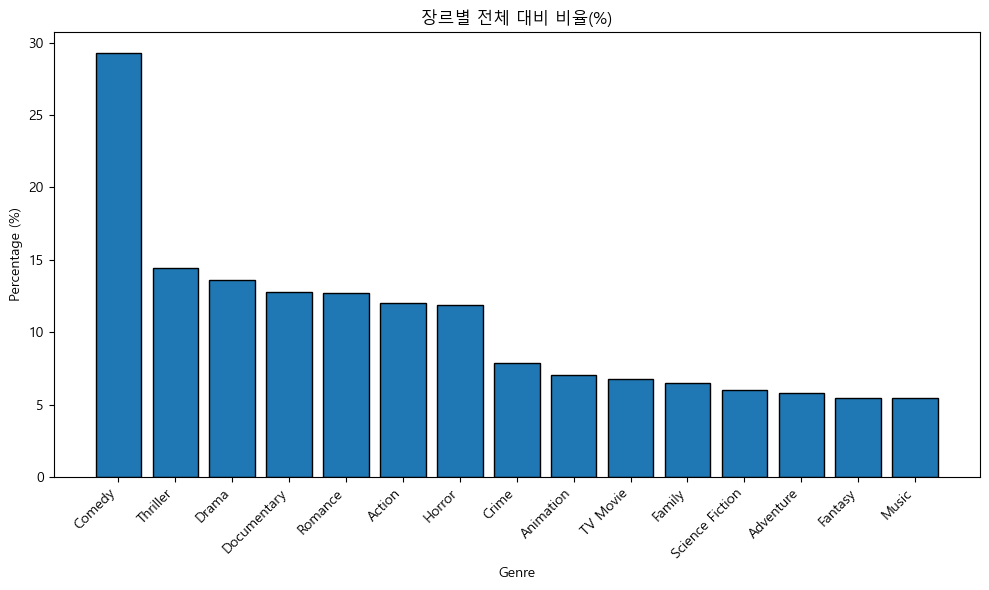

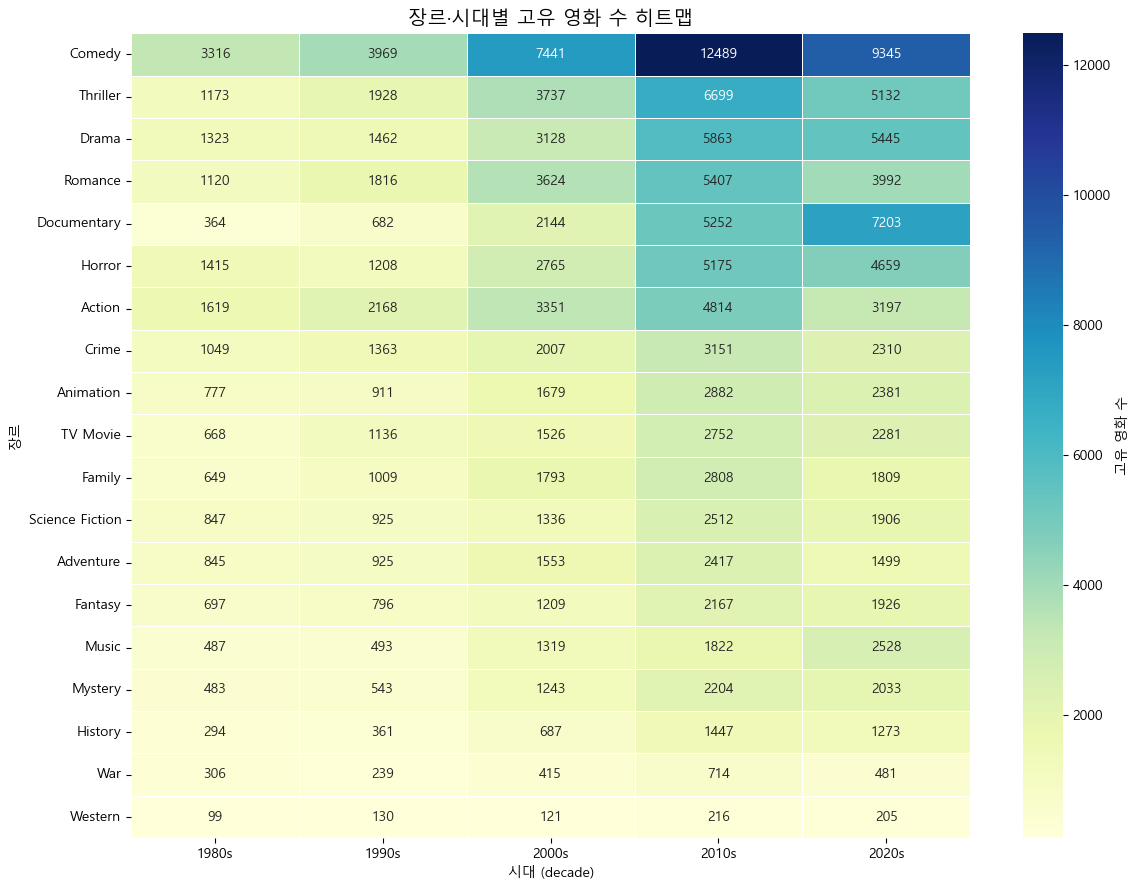


4. 머신러닝 모델링...
   모델링 데이터: 129,958개 샘플, 24개 특성

5. 로지스틱 회귀 모델 학습...
[1단계] 분류 리포트 (기타 vs 상위)
              precision    recall  f1-score   support

          기타      0.715     0.688     0.701     15330
          상위      0.574     0.605     0.589     10662

    accuracy                          0.654     25992
   macro avg      0.644     0.646     0.645     25992
weighted avg      0.657     0.654     0.655     25992

[1단계] Balanced Accuracy: 0.646

[2단계] 분류 리포트 (평범/성공/대성공)
              precision    recall  f1-score   support

         대성공      0.574     0.857     0.688      2629
          성공      0.184     0.488     0.268       761
          평범      0.750     0.127     0.217      3064

    accuracy                          0.467      6454
   macro avg      0.503     0.491     0.391      6454
weighted avg      0.612     0.467     0.415      6454

[2단계] Balanced Accuracy: 0.491

[최종] 전체 테스트 세트 평가
              precision    recall  f1-score   support

          기타      0.785     1.000    

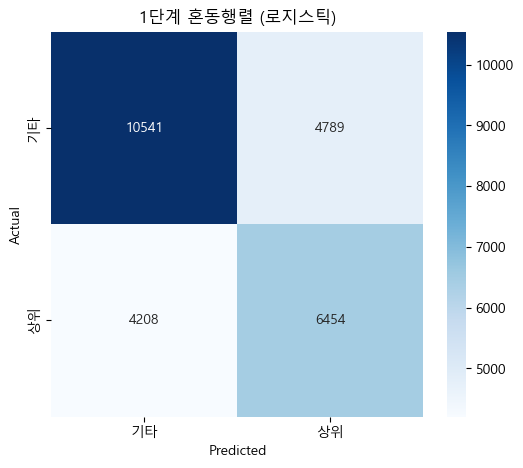

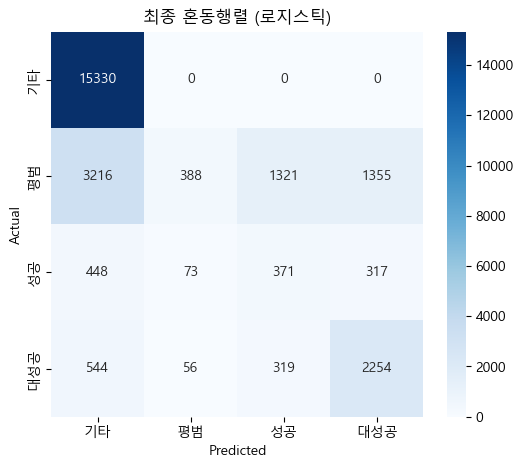

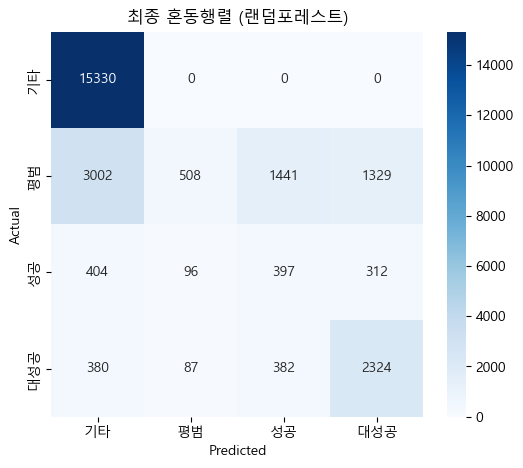

로지스틱 회귀 특성 중요도:


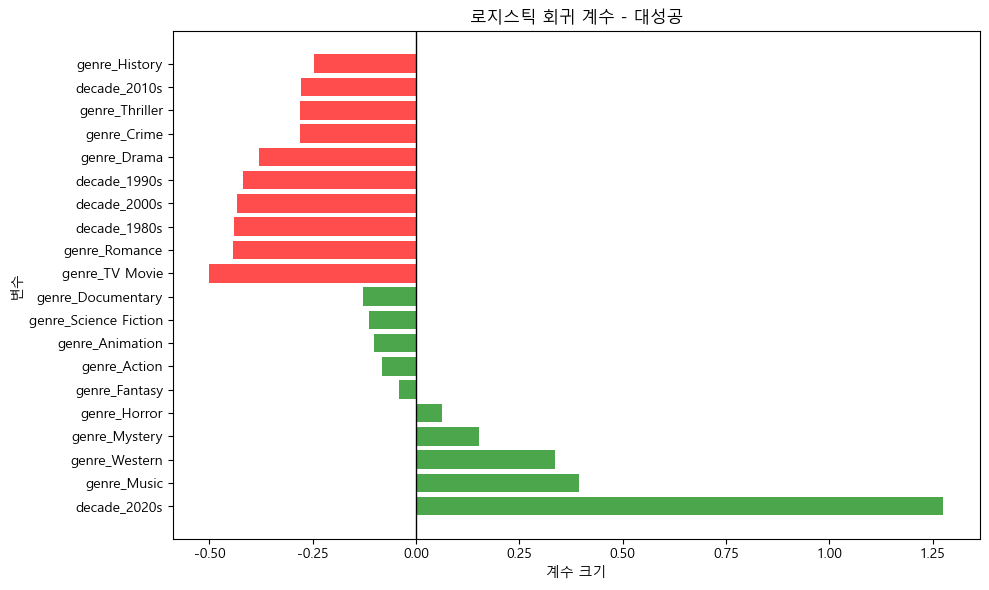

랜덤포레스트 특성 중요도:


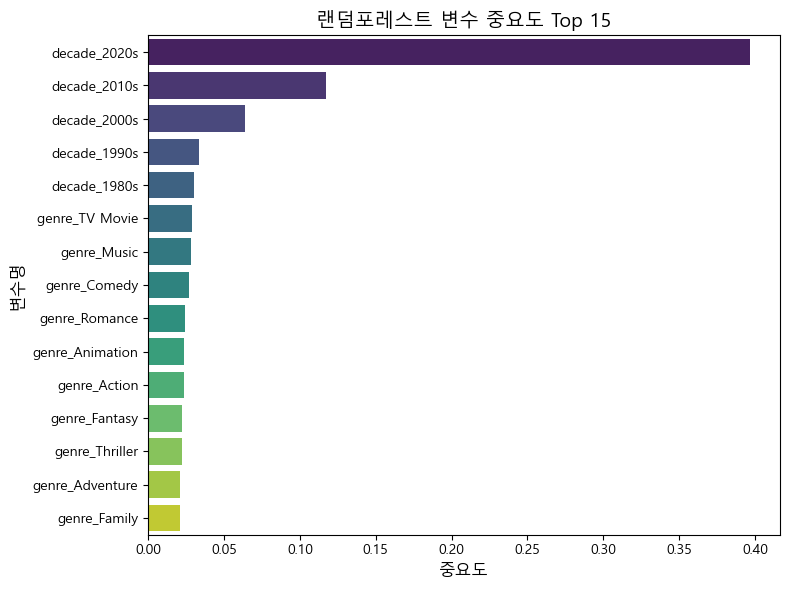


=== 분석 완료 ===

=== 분석 결과 요약 ===
총 분석 샘플: 129,958개
사용된 특성: 24개
상위 장르: 19개


In [1]:
# -*- coding: utf-8 -*-
"""
TMDB 영화 분석 및 예측 시스템
- 영화 데이터 전처리, 분석, 시각화 및 머신러닝 예측
- 장르와 시대 기반 평점 예측 모델
"""

import json
import warnings
from typing import Dict, List, Tuple, Optional, Union, Any
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    balanced_accuracy_score
)
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')

# ============================================================================
# 상수 및 설정
# ============================================================================

class Config:
    """프로젝트 전반에 사용되는 설정값들"""
    
    # 데이터 처리 설정
    ANALYSIS_YEAR_START = 1980
    ANALYSIS_YEAR_END = 2025
    VOTE_COUNT_CUTOFF_EARLY = 4  # 1980-2019년
    VOTE_COUNT_CUTOFF_LATE = 1   # 2020-2025년
    EARLY_CUTOFF_YEAR = 2020
    
    # 평점 구간 설정
    RATING_THRESHOLDS = {
        'good': 6.5,
        'success': 7.5,
        'great_success': 8.0
    }
    
    # 모델링 설정
    TOP_K_GENRES = 25
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # 시각화 설정
    FIGURE_SIZE_DEFAULT = (8, 6)
    FIGURE_SIZE_LARGE = (12, 8)
    
    # 제외할 장르 (다른 장르와 함께 있을 때)
    EXCLUDE_IF_COMBINED = ["Drama", "Documentary"]

# 전역 시각화 설정
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# ============================================================================
# 유틸리티 함수들
# ============================================================================

def to_numeric_safe(x: Any) -> float:
    """
    문자열/숫자 혼합 데이터를 안전하게 숫자로 변환
    
    Args:
        x: 변환할 값
        
    Returns:
        float: 변환된 숫자 또는 NaN
    """
    try:
        if isinstance(x, str):
            x = x.replace(",", "").strip()
        return pd.to_numeric(x, errors="coerce")
    except Exception:
        return np.nan

def parse_genres(val: Any) -> List[str]:
    """
    장르 컬럼을 장르명 리스트로 변환
    
    Args:
        val: 장르 데이터 (문자열, 리스트, 또는 기타)
        
    Returns:
        List[str]: 파싱된 장르명 리스트
    """
    if isinstance(val, list):
        names = []
        for item in val:
            if isinstance(item, dict) and "name" in item:
                names.append(str(item["name"]).strip())
            else:
                names.append(str(item).strip())
        return names

    if isinstance(val, str):
        s = val.strip()
        if s in ("", "[]"):
            return []
        
        try:
            obj = json.loads(s.replace("'", '"'))
            if isinstance(obj, list):
                names = []
                for item in obj:
                    if isinstance(item, dict) and "name" in item:
                        names.append(str(item["name"]).strip())
                    else:
                        names.append(str(item).strip())
                return names
        except Exception:
            pass
        
        if "," in s:
            return [tok.strip() for tok in s.split(",") if tok.strip()]
        return [s]

    return []

def filter_genres(genres_list: List[str], 
                 exclude_if_combined: Optional[List[str]] = None) -> List[str]:
    """
    드라마/다큐멘터리는 단일 장르일 때만 인정하고, 다른 장르와 함께 있으면 제외
    
    Args:
        genres_list: 장르 리스트
        exclude_if_combined: 다른 장르와 함께 있을 때 제외할 장르들
        
    Returns:
        List[str]: 필터링된 장르 리스트
    """
    if exclude_if_combined is None:
        exclude_if_combined = Config.EXCLUDE_IF_COMBINED

    if not isinstance(genres_list, list) or len(genres_list) <= 1:
        return genres_list if isinstance(genres_list, list) else []

    return [g for g in genres_list if g not in exclude_if_combined]

def categorize_rating(rating: float) -> str:
    """
    평점을 카테고리로 분류
    
    Args:
        rating: 평점 값
        
    Returns:
        str: 평점 카테고리 ('기타', '평범', '성공', '대성공')
    """
    if rating >= Config.RATING_THRESHOLDS['great_success']:
        return "대성공"
    elif rating >= Config.RATING_THRESHOLDS['success']:
        return "성공"
    elif rating >= Config.RATING_THRESHOLDS['good']:
        return "평범"
    else:
        return "기타"

# ============================================================================
# 데이터 전처리 함수들
# ============================================================================

class DataProcessor:
    """데이터 전처리를 담당하는 클래스"""
    
    @staticmethod
    def ensure_datetime(df: pd.DataFrame, 
                       date_col: str = "release_date") -> pd.DataFrame:
        """
        문자열 날짜를 datetime으로 변환
        
        Args:
            df: 데이터프레임
            date_col: 날짜 컬럼명
            
        Returns:
            pd.DataFrame: datetime 변환된 데이터프레임
        """
        df_copy = df.copy()
        df_copy[date_col] = pd.to_datetime(df_copy[date_col], errors="coerce")
        return df_copy

    @staticmethod
    def add_year_and_decade(df: pd.DataFrame, 
                           date_col: str = "release_date") -> pd.DataFrame:
        """
        연도와 시대(decade) 컬럼 추가
        
        Args:
            df: 데이터프레임
            date_col: 날짜 컬럼명
            
        Returns:
            pd.DataFrame: 연도와 시대 컬럼이 추가된 데이터프레임
        """
        df_copy = df.copy()
        df_copy["year"] = df_copy[date_col].dt.year.astype("Int64")
        df_copy = df_copy[df_copy["year"].notna()].copy()
        df_copy["year"] = df_copy["year"].astype(int)
        df_copy["decade"] = ((df_copy["year"] // 10) * 10).astype(str) + "s"
        return df_copy

    @staticmethod
    def explode_genres(df: pd.DataFrame, 
                      src: str = "genres_filtered", 
                      dst: str = "genre") -> pd.DataFrame:
        """
        장르 리스트를 행으로 분리
        
        Args:
            df: 데이터프레임
            src: 소스 컬럼명
            dst: 대상 컬럼명
            
        Returns:
            pd.DataFrame: 장르가 행으로 분리된 데이터프레임
        """
        df_copy = df.copy()
        if src != dst:
            df_copy = df_copy.rename(columns={src: dst})
        
        df_copy = df_copy.explode(dst)
        df_copy = df_copy[df_copy[dst].notna() & 
                         (df_copy[dst].astype(str).str.strip() != "")].copy()
        df_copy[dst] = df_copy[dst].astype(str).str.strip()
        return df_copy

    @staticmethod
    def apply_vote_cut_rules(df: pd.DataFrame, 
                           year_col: str = "year", 
                           vote_col: str = "vote_count") -> pd.DataFrame:
        """
        투표 컷오프 규칙 적용
        
        Args:
            df: 데이터프레임
            year_col: 연도 컬럼명
            vote_col: 투표수 컬럼명
            
        Returns:
            pd.DataFrame: 투표 컷오프가 적용된 데이터프레임
        """
        base = df[(df[year_col] >= Config.ANALYSIS_YEAR_START) & 
                  (df[year_col] <= Config.ANALYSIS_YEAR_END)].copy()
        
        early = base[(base[year_col] < Config.EARLY_CUTOFF_YEAR) & 
                     (base[vote_col] >= Config.VOTE_COUNT_CUTOFF_EARLY)]
        late = base[(base[year_col] >= Config.EARLY_CUTOFF_YEAR) & 
                    (base[vote_col] >= Config.VOTE_COUNT_CUTOFF_LATE)]
        
        return pd.concat([early, late], ignore_index=True)

    def preprocess_data(self, df_raw: pd.DataFrame) -> pd.DataFrame:
        """
        전체 데이터 전처리 파이프라인
        
        Args:
            df_raw: 원본 데이터프레임
            
        Returns:
            pd.DataFrame: 전처리된 데이터프레임
        """
        df_pre = df_raw.copy()

        # 숫자형 변환
        for col in ["vote_average", "revenue", "budget"]:
            if col in df_pre.columns:
                df_pre[col] = df_pre[col].apply(to_numeric_safe)

        # 장르 파싱 및 필터링
        df_pre["genres_parsed"] = df_pre["genres"].apply(parse_genres)
        df_pre["genres_filtered"] = df_pre["genres_parsed"].apply(filter_genres)

        # 날짜 변환 및 연도/시대 추가
        df_pre = self.ensure_datetime(df_pre, "release_date")
        df_pre = self.add_year_and_decade(df_pre, "release_date")

        return df_pre

    def build_base_dataset(self, df_pre: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        분석용 기본 데이터셋 구축
        
        Args:
            df_pre: 전처리된 데이터프레임
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: (장르 분리된 전체 데이터, 컷오프 적용된 데이터)
        """
        df_exploded = self.explode_genres(df_pre, src="genres_filtered", dst="genre")
        df_cut = self.apply_vote_cut_rules(df_exploded, year_col="year", vote_col="vote_count")
        return df_exploded, df_cut

# ============================================================================
# 분석 함수들
# ============================================================================

class MovieAnalyzer:
    """영화 데이터 분석을 담당하는 클래스"""
    
    @staticmethod
    def compute_genre_share(df: pd.DataFrame, 
                           group_cols: Tuple[str, ...] = ("genre",), 
                           title_col: str = "title") -> pd.DataFrame:
        """
        장르별 고유 영화 수 및 전체 대비 비율 계산
        
        Args:
            df: 데이터프레임
            group_cols: 그룹핑할 컬럼들
            title_col: 제목 컬럼명
            
        Returns:
            pd.DataFrame: 장르별 통계 데이터프레임
        """
        total_unique = df[title_col].nunique()
        genre_unique_counts = (
            df.groupby(list(group_cols))[title_col]
            .nunique()
            .reset_index()
            .rename(columns={title_col: "unique_movie_count"})
        )
        genre_unique_counts["percentage_unique"] = (
            genre_unique_counts["unique_movie_count"] / total_unique * 100
        ).round(2)
        return genre_unique_counts.sort_values("unique_movie_count", ascending=False)

    @staticmethod
    def pivot_decade_genre_counts(df: pd.DataFrame, 
                                 count_col: str = "title", 
                                 agg: str = "count") -> pd.DataFrame:
        """
        시대×장르별 영화 수 피벗 생성
        
        Args:
            df: 데이터프레임
            count_col: 집계할 컬럼명
            agg: 집계 방법 ('count' 또는 'nunique')
            
        Returns:
            pd.DataFrame: 피벗 테이블
        """
        if agg == "nunique":
            grouped = (
                df.groupby(["decade", "genre"])[count_col]
                .nunique()
                .reset_index(name="movie_count")
            )
        else:
            grouped = (
                df.groupby(["decade", "genre"])[count_col]
                .count()
                .reset_index(name="movie_count")
            )
        return grouped.pivot(index="genre", columns="decade", values="movie_count").fillna(0)

    @staticmethod
    def analyze_rating_band(df_base: pd.DataFrame, 
                           rating_min: Optional[float] = None, 
                           rating_max: Optional[float] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        특정 평점 구간의 장르×시대 분석
        
        Args:
            df_base: 기본 데이터프레임
            rating_min: 최소 평점
            rating_max: 최대 평점
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: (집계 데이터, 비율 피벗)
        """
        filt = df_base.copy()
        if rating_min is not None:
            filt = filt[filt["vote_average"] >= rating_min]
        if rating_max is not None:
            filt = filt[filt["vote_average"] < rating_max]

        counts = (
            filt.groupby(["genre", "decade"])["title"]
            .nunique()
            .reset_index(name="movie_count")
        )

        totals = filt.groupby("decade")["title"].nunique().to_dict()

        counts["percentage"] = counts.apply(
            lambda row: (row["movie_count"] / totals[row["decade"]] * 100) 
            if totals.get(row["decade"], 0) else 0.0,
            axis=1
        ).round(2)

        pivot_pct = counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)
        return counts, pivot_pct

# ============================================================================
# 시각화 함수들
# ============================================================================

class Visualizer:
    """데이터 시각화를 담당하는 클래스"""
    
    @staticmethod
    def plot_hist(series: pd.Series, 
                  bins: int = 30, 
                  title: str = "", 
                  xlabel: str = "", 
                  ylabel: str = "count",
                  figsize: Tuple[int, int] = Config.FIGURE_SIZE_DEFAULT) -> None:
        """
        히스토그램 플롯
        
        Args:
            series: 플롯할 시리즈
            bins: 구간 수
            title: 제목
            xlabel: x축 라벨
            ylabel: y축 라벨
            figsize: 그래프 크기
        """
        plt.figure(figsize=figsize)
        plt.hist(series.dropna(), bins=bins, edgecolor="black")
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_bar(x: pd.Series, 
                 y: pd.Series, 
                 title: str = "", 
                 xlabel: str = "", 
                 ylabel: str = "", 
                 rotate: int = 45,
                 figsize: Tuple[int, int] = Config.FIGURE_SIZE_DEFAULT) -> None:
        """
        막대그래프 플롯
        
        Args:
            x: x축 데이터
            y: y축 데이터
            title: 제목
            xlabel: x축 라벨
            ylabel: y축 라벨
            rotate: x축 라벨 회전각도
            figsize: 그래프 크기
        """
        plt.figure(figsize=figsize)
        plt.bar(x, y, edgecolor="black")
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=rotate, ha="right")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_heatmap(pivot_df: pd.DataFrame, 
                     title: str = "", 
                     fmt: str = ".1f", 
                     vmin: Optional[float] = None, 
                     vmax: Optional[float] = None,
                     figsize: Tuple[int, int] = Config.FIGURE_SIZE_LARGE) -> None:
        """
        히트맵 플롯
        
        Args:
            pivot_df: 피벗 데이터프레임
            title: 제목
            fmt: 숫자 형식
            vmin: 최소값
            vmax: 최대값
            figsize: 그래프 크기
        """
        plt.figure(figsize=figsize)
        sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu", vmin=vmin, vmax=vmax)
        plt.title(title)
        plt.ylabel("Genre")
        plt.xlabel("Decade")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(y_true: np.ndarray, 
                             y_pred: np.ndarray, 
                             labels: List[str], 
                             title: str,
                             figsize: Tuple[int, int] = (6, 5)) -> None:
        """
        혼동행렬 플롯
        
        Args:
            y_true: 실제 값
            y_pred: 예측 값
            labels: 클래스 라벨
            title: 제목
            figsize: 그래프 크기
        """
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(title)
        plt.show()

    def plot_genre_decade_heatmap(self, 
                                  df_base: pd.DataFrame,
                                  top_n: int = 20,
                                  how: str = "unique",
                                  cmap: str = "YlGnBu",
                                  annotate: bool = True,
                                  figsize: Tuple[int, int] = (12, 9),
                                  title: Optional[str] = None) -> pd.DataFrame:
        """
        장르×시대 히트맵 플롯
        
        Args:
            df_base: 기본 데이터프레임
            top_n: 상위 N개 장르
            how: 집계 방법 ('unique' 또는 'count')
            cmap: 컬러맵
            annotate: 숫자 표시 여부
            figsize: 그래프 크기
            title: 제목
            
        Returns:
            pd.DataFrame: 피벗 테이블
        """
        req = {"title", "decade", "genre"}
        if not req.issubset(df_base.columns):
            miss = list(req - set(df_base.columns))
            raise ValueError(f"필수 컬럼 누락: {miss}")

        df = df_base.copy()
        df = df[df["genre"].notna() & (df["genre"].astype(str).str.strip() != "")]
        df["genre"] = df["genre"].astype(str).str.strip()

        genre_totals = (
            df.groupby("genre")["title"].nunique()
            .sort_values(ascending=False)
        )
        top_genres = genre_totals.index[:top_n]

        if how == "unique":
            grouped = (
                df[df["genre"].isin(top_genres)]
                .groupby(["genre", "decade"])["title"]
                .nunique()
                .reset_index(name="count")
            )
            value_label = "고유 영화 수"
        elif how == "count":
            grouped = (
                df[df["genre"].isin(top_genres)]
                .groupby(["genre", "decade"])["title"]
                .count()
                .reset_index(name="count")
            )
            value_label = "작품 수(중복 포함)"
        else:
            raise ValueError('how는 "unique" 또는 "count"만 가능합니다.')

        pivot = grouped.pivot(index="genre", columns="decade", values="count").fillna(0)

        order = pivot.sum(axis=1).sort_values(ascending=False).index
        pivot = pivot.loc[order]
        pivot = pivot.reindex(sorted(pivot.columns), axis=1)

        plt.figure(figsize=figsize)
        sns.heatmap(
            pivot,
            cmap=cmap,
            annot=annotate,
            fmt=".0f",
            linewidths=0.4,
            cbar_kws={"label": value_label},
        )
        plt.title(title or f"장르·시대별 {value_label} (Top {top_n} 장르)", fontsize=14)
        plt.xlabel("시대 (decade)")
        plt.ylabel("장르")
        plt.tight_layout()
        plt.show()

        return pivot

# ============================================================================
# 머신러닝 모델링
# ============================================================================

class ModelingPipeline:
    """머신러닝 모델링 파이프라인을 담당하는 클래스"""
    
    def __init__(self, config: Config = Config()):
        self.config = config
    
    def build_modeling_table(self, 
                           df_base: pd.DataFrame,
                           top_k_genres: int = None,
                           safety_checks: bool = True) -> Tuple[pd.DataFrame, pd.Series, pd.Series, pd.DataFrame, Dict]:
        """
        모델링용 테이블 구축
        
        Args:
            df_base: 기본 데이터프레임
            top_k_genres: 상위 K개 장르 수
            safety_checks: 안전성 체크 여부
            
        Returns:
            Tuple: (특성 데이터, 회귀 타겟, 분류 타겟, 모델링 데이터, 메타정보)
        """
        if top_k_genres is None:
            top_k_genres = self.config.TOP_K_GENRES
            
        req_cols = {"title", "decade", "genre", "vote_average"}
        if safety_checks and not req_cols.issubset(df_base.columns):
            missing = list(req_cols - set(df_base.columns))
            raise ValueError(f"필수 컬럼 누락: {missing}")

        # 장르 멀티핫 인코딩
        genre_dum = pd.get_dummies(df_base["genre"], prefix="genre")

        # 상위 K개 장르 선택
        genre_counts = (
            df_base.groupby("genre")["title"]
            .nunique()
            .sort_values(ascending=False)
        )
        top_genres = [f"genre_{g}" for g in genre_counts.index[:top_k_genres]]

        # 영화 단위로 집계
        tmp = pd.concat([
            df_base[["title", "decade", "vote_average"]].reset_index(drop=True),
            genre_dum.reset_index(drop=True)
        ], axis=1)
        
        agg_dict = {"vote_average": "mean", **{col: "max" for col in genre_dum.columns}}
        df_model = tmp.groupby(["title", "decade"], as_index=False).agg(agg_dict)

        # 상위 K개 장르만 유지
        for col in top_genres:
            if col not in df_model.columns:
                df_model[col] = 0
        keep_cols = ["title", "decade", "vote_average"] + top_genres
        df_model = df_model[keep_cols]

        # 시대 더미화
        decade_dum = pd.get_dummies(df_model["decade"], prefix="decade")

        # 특성과 타겟 구성
        X = pd.concat([decade_dum, df_model[top_genres]], axis=1)
        y_reg = df_model["vote_average"].copy()
        y_cls = y_reg.apply(categorize_rating)

        # 결측값 제거
        valid = y_reg.notna()
        X = X.loc[valid].reset_index(drop=True)
        y_reg = y_reg.loc[valid].reset_index(drop=True)
        y_cls = y_cls.loc[valid].reset_index(drop=True)
        df_model = df_model.loc[valid].reset_index(drop=True)

        info = {
            "n_samples": len(df_model),
            "n_features": X.shape[1],
            "top_genres_used": top_genres,
            "decades_used": list(decade_dum.columns),
        }
        
        return X, y_reg, y_cls, df_model, info

    def train_two_stage_classifier(self, 
                                  X: pd.DataFrame, 
                                  y_cls: pd.Series,
                                  model_type: str = "random_forest") -> Dict:
        """
        2단계 분류기 학습
        
        Args:
            X: 특성 데이터
            y_cls: 분류 타겟
            model_type: 모델 타입 ('logistic' 또는 'random_forest')
            
        Returns:
            Dict: 학습된 모델들과 결과
        """
        # 데이터 분할
        X_train, X_test, y_train_full, y_test_full = train_test_split(
            X, y_cls, test_size=self.config.TEST_SIZE, 
            random_state=self.config.RANDOM_STATE, stratify=y_cls
        )

        # 1단계: 기타 vs 상위 분류
        y1_train = np.where(y_train_full == "기타", "기타", "상위")
        y1_test = np.where(y_test_full == "기타", "기타", "상위")

        if model_type == "logistic":
            clf_stage1 = LogisticRegression(
                solver='lbfgs',
                max_iter=1000,
                class_weight='balanced',
                random_state=self.config.RANDOM_STATE
            )
        else:  # random_forest
            clf_stage1 = RandomForestClassifier(
                n_estimators=400,
                max_depth=None,
                min_samples_leaf=2,
                class_weight='balanced_subsample',
                random_state=self.config.RANDOM_STATE,
                n_jobs=-1
            )

        clf_stage1.fit(X_train, y1_train)
        y1_pred = clf_stage1.predict(X_test)

        # 2단계: 상위 내에서 세부 분류
        mask_train_upper = (y1_train == "상위")
        proba_test = clf_stage1.predict_proba(X_test)
        idx_upper = list(clf_stage1.classes_).index("상위")
        mask_test_upper = (proba_test[:, idx_upper] >= 0.5)

        X_train_s2 = X_train.loc[mask_train_upper]
        y2_train = y_train_full[mask_train_upper]
        X_test_s2 = X_test.loc[mask_test_upper]
        y2_test_gt = y_test_full[mask_test_upper]

        # '기타' 제거 (2단계에서는 평범/성공/대성공만)
        train_mask_no_etc = (y2_train != "기타")
        test_mask_no_etc = (y2_test_gt != "기타")

        X_train_s2 = X_train_s2.loc[train_mask_no_etc]
        y2_train = y2_train[train_mask_no_etc]
        X_test_s2 = X_test_s2.loc[test_mask_no_etc]
        y2_test_gt = y2_test_gt[test_mask_no_etc]

        # 오버샘플링으로 불균형 보정
        if len(y2_train) > 0:
            ros = RandomOverSampler(random_state=self.config.RANDOM_STATE)
            X_train_s2_bal, y2_train_bal = ros.fit_resample(X_train_s2, y2_train)

            if model_type == "logistic":
                clf_stage2 = LogisticRegression(
                    solver="lbfgs",
                    max_iter=1000,
                    random_state=self.config.RANDOM_STATE
                )
            else:  # random_forest
                clf_stage2 = RandomForestClassifier(
                    n_estimators=600,
                    max_depth=None,
                    min_samples_leaf=2,
                    class_weight='balanced_subsample',
                    random_state=self.config.RANDOM_STATE,
                    n_jobs=-1
                )

            clf_stage2.fit(X_train_s2_bal, y2_train_bal)

            # 2단계 예측
            if len(X_test_s2) > 0:
                y2_pred = clf_stage2.predict(X_test_s2)
            else:
                y2_pred = np.array([], dtype=object)
        else:
            clf_stage2 = None
            y2_pred = np.array([], dtype=object)

        # 최종 예측 조합
        final_pred = np.array(["기타"] * len(y_test_full), dtype=object)
        if len(y2_pred) > 0:
            pos_map = {idx: i for i, idx in enumerate(X_test.index)}
            pos_list = [pos_map[idx] for idx in X_test_s2.index]
            final_pred[pos_list] = y2_pred

        return {
            'stage1_model': clf_stage1,
            'stage2_model': clf_stage2,
            'y_test_full': y_test_full,
            'y1_test': y1_test,
            'y1_pred': y1_pred,
            'y2_test_gt': y2_test_gt,
            'y2_pred': y2_pred,
            'final_pred': final_pred,
            'X_test': X_test,
            'X_train': X_train
        }

    def evaluate_model(self, results: Dict) -> None:
        """
        모델 평가 결과 출력
        
        Args:
            results: train_two_stage_classifier 결과
        """
        print("[1단계] 분류 리포트 (기타 vs 상위)")
        print(classification_report(results['y1_test'], results['y1_pred'], 
                                  digits=3, zero_division=0))
        print("[1단계] Balanced Accuracy:",
              round(balanced_accuracy_score(results['y1_test'], results['y1_pred']), 3))

        if len(results['y2_pred']) > 0:
            print("\n[2단계] 분류 리포트 (평범/성공/대성공)")
            print(classification_report(results['y2_test_gt'], results['y2_pred'], 
                                      digits=3, zero_division=0))
            print("[2단계] Balanced Accuracy:",
                  round(balanced_accuracy_score(results['y2_test_gt'], results['y2_pred']), 3))

        print("\n[최종] 전체 테스트 세트 평가")
        print(classification_report(results['y_test_full'], results['final_pred'], 
                                  digits=3, zero_division=0))
        print("[최종] Balanced Accuracy:",
              round(balanced_accuracy_score(results['y_test_full'], results['final_pred']), 3))

    def analyze_feature_importance(self, 
                                 results: Dict, 
                                 X: pd.DataFrame,
                                 target_class: str = "대성공") -> None:
        """
        특성 중요도 분석 및 시각화
        
        Args:
            results: 모델 학습 결과
            X: 특성 데이터
            target_class: 분석할 대상 클래스
        """
        stage1_model = results['stage1_model']
        stage2_model = results['stage2_model']

        # 로지스틱 회귀 계수 분석 (2단계 모델이 로지스틱인 경우)
        if hasattr(stage2_model, 'coef_') and stage2_model is not None:
            classes = stage2_model.classes_
            if target_class in classes:
                cls_idx = list(classes).index(target_class)
                coef_df = pd.DataFrame({
                    "feature": X.columns,
                    "coef": stage2_model.coef_[cls_idx]
                })
                coef_df["coef_abs"] = coef_df["coef"].abs()
                
                top_positive = coef_df.sort_values("coef", ascending=False).head(10)
                top_negative = coef_df.sort_values("coef", ascending=True).head(10)

                plt.figure(figsize=(10, 6))
                plt.barh(top_positive["feature"], top_positive["coef"], color="green", alpha=0.7)
                plt.barh(top_negative["feature"], top_negative["coef"], color="red", alpha=0.7)
                plt.axvline(0, color="black", linewidth=1)
                plt.title(f"로지스틱 회귀 계수 - {target_class}")
                plt.xlabel("계수 크기")
                plt.ylabel("변수")
                plt.tight_layout()
                plt.show()

        # 랜덤포레스트 중요도 분석 (2단계 모델이 랜덤포레스트인 경우)
        if hasattr(stage2_model, 'feature_importances_') and stage2_model is not None:
            fi_df = pd.DataFrame({
                'feature': X.columns,
                'importance': stage2_model.feature_importances_
            })
            fi_df = fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

            plt.figure(figsize=(8, 6))
            sns.barplot(data=fi_df.head(15), x='importance', y='feature', palette='viridis')
            plt.title("랜덤포레스트 변수 중요도 Top 15", fontsize=14)
            plt.xlabel("중요도", fontsize=12)
            plt.ylabel("변수명", fontsize=12)
            plt.tight_layout()
            plt.show()

            return fi_df.head(15)

# ============================================================================
# 메인 분석 파이프라인
# ============================================================================

class TMDBAnalyzer:
    """TMDB 영화 데이터 종합 분석 클래스"""
    
    def __init__(self, config: Config = Config()):
        self.config = config
        self.processor = DataProcessor()
        self.analyzer = MovieAnalyzer()
        self.visualizer = Visualizer()
        self.modeler = ModelingPipeline(config)
    
    def run_complete_analysis(self, df_raw: pd.DataFrame) -> Dict:
        """
        전체 분석 파이프라인 실행
        
        Args:
            df_raw: 원본 데이터프레임
            
        Returns:
            Dict: 분석 결과들
        """
        print("=== TMDB 영화 데이터 분석 시작 ===\n")
        
        # 1. 데이터 전처리
        print("1. 데이터 전처리 중...")
        df_pre = self.processor.preprocess_data(df_raw)
        df_exploded_all, df_base = self.processor.build_base_dataset(df_pre)
        print(f"   전처리 완료: {len(df_base):,}개 샘플")
        
        # 2. 기본 EDA
        print("\n2. 기본 탐색적 데이터 분석...")
        self._perform_basic_eda(df_raw, df_base)
        
        # 3. 장르/시대 분석
        print("\n3. 장르 및 시대별 분석...")
        genre_analysis = self._perform_genre_analysis(df_base)
        
        # 4. 모델링 테이블 구축
        print("\n4. 머신러닝 모델링...")
        X, y_reg, y_cls, df_model, info = self.modeler.build_modeling_table(df_base)
        print(f"   모델링 데이터: {info['n_samples']:,}개 샘플, {info['n_features']}개 특성")
        
        # 5. 모델 학습 및 평가
        print("\n5. 로지스틱 회귀 모델 학습...")
        log_results = self.modeler.train_two_stage_classifier(X, y_cls, "logistic")
        self.modeler.evaluate_model(log_results)
        
        print("\n6. 랜덤포레스트 모델 학습...")
        rf_results = self.modeler.train_two_stage_classifier(X, y_cls, "random_forest")
        self.modeler.evaluate_model(rf_results)
        
        # 6. 시각화
        print("\n7. 결과 시각화...")
        self._create_visualizations(df_base, log_results, rf_results, X)
        
        print("\n=== 분석 완료 ===")
        
        return {
            'df_base': df_base,
            'modeling_info': info,
            'logistic_results': log_results,
            'rf_results': rf_results,
            'genre_analysis': genre_analysis,
            'X': X,
            'y_cls': y_cls
        }
    
    def _perform_basic_eda(self, df_raw: pd.DataFrame, df_base: pd.DataFrame) -> None:
        """기본 탐색적 데이터 분석"""
        # 평점 분포
        if "vote_average" in df_raw.columns:
            self.visualizer.plot_hist(
                df_raw["vote_average"], 
                bins=30, 
                title="전체 평점 분포", 
                xlabel="vote_average"
            )
        
        # 컷오프 후 평점 분포
        self.visualizer.plot_hist(
            df_base["vote_average"], 
            bins=30, 
            title="컷오프 후 평점 분포", 
            xlabel="vote_average"
        )
        
        # 평점 구간별 비율
        df_base_copy = df_base.copy()
        df_base_copy["rating_category"] = df_base_copy["vote_average"].apply(categorize_rating)
        cat_counts = df_base_copy["rating_category"].value_counts().reindex(
            ["기타", "평범", "성공", "대성공"]
        )
        cat_ratios = (cat_counts / len(df_base_copy) * 100).round(2)
        print("평점 구간별 비율(%):")
        print(cat_ratios)
    
    def _perform_genre_analysis(self, df_base: pd.DataFrame) -> Dict:
        """장르 및 시대별 분석"""
        # 장르별 점유율
        genre_share = self.analyzer.compute_genre_share(df_base)
        print(f"상위 10개 장르:")
        print(genre_share.head(10)[['genre', 'percentage_unique']])
        
        # 시각화
        self.visualizer.plot_bar(
            x=genre_share.head(15)["genre"],
            y=genre_share.head(15)["percentage_unique"],
            title="장르별 전체 대비 비율(%)",
            xlabel="Genre",
            ylabel="Percentage (%)",
            figsize=(10, 6)
        )
        
        # 장르×시대 히트맵
        pivot_unique = self.visualizer.plot_genre_decade_heatmap(
            df_base,
            top_n=20,
            how="unique",
            title="장르·시대별 고유 영화 수 히트맵"
        )
        
        return {
            'genre_share': genre_share,
            'pivot_unique': pivot_unique
        }
    
    def _create_visualizations(self, 
                             df_base: pd.DataFrame,
                             log_results: Dict, 
                             rf_results: Dict,
                             X: pd.DataFrame) -> None:
        """결과 시각화 생성"""
        # 혼동행렬
        self.visualizer.plot_confusion_matrix(
            log_results['y1_test'], 
            log_results['y1_pred'],
            ["기타", "상위"],
            "1단계 혼동행렬 (로지스틱)"
        )
        
        self.visualizer.plot_confusion_matrix(
            log_results['y_test_full'], 
            log_results['final_pred'],
            ["기타", "평범", "성공", "대성공"],
            "최종 혼동행렬 (로지스틱)"
        )
        
        self.visualizer.plot_confusion_matrix(
            rf_results['y_test_full'], 
            rf_results['final_pred'],
            ["기타", "평범", "성공", "대성공"],
            "최종 혼동행렬 (랜덤포레스트)"
        )
        
        # 특성 중요도 분석
        print("로지스틱 회귀 특성 중요도:")
        self.modeler.analyze_feature_importance(log_results, X, "대성공")
        
        print("랜덤포레스트 특성 중요도:")
        self.modeler.analyze_feature_importance(rf_results, X, "대성공")

# ============================================================================
# 실행 예시
# ============================================================================

def main(csv_path: str) -> Dict:
    """
    메인 실행 함수
    
    Args:
        csv_path: CSV 파일 경로
        
    Returns:
        Dict: 전체 분석 결과
    """
    # 데이터 로드
    try:
        df_raw = pd.read_csv(csv_path)
        print(f"데이터 로드 완료: {len(df_raw):,}개 행, {len(df_raw.columns)}개 컬럼")
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {csv_path}")
        return {}
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return {}
    
    # 필수 컬럼 확인
    required_cols = ["vote_average", "revenue", "budget", "genres", 
                    "release_date", "vote_count", "title"]
    missing = [c for c in required_cols if c not in df_raw.columns]
    if missing:
        print(f"[경고] 다음 컬럼이 존재하지 않습니다: {missing}")
        return {}
    
    # 분석 실행
    analyzer = TMDBAnalyzer()
    results = analyzer.run_complete_analysis(df_raw)
    
    return results

if __name__ == "__main__":
    # 사용 예시
    CSV_PATH = "TMDB_movie_dataset_v11.csv"  # 실제 경로로 변경
    
    # 전체 분석 실행
    analysis_results = main(CSV_PATH)
    
    # 결과 활용 예시
    if analysis_results:
        print("\n=== 분석 결과 요약 ===")
        info = analysis_results.get('modeling_info', {})
        print(f"총 분석 샘플: {info.get('n_samples', 0):,}개")
        print(f"사용된 특성: {info.get('n_features', 0)}개")
        print(f"상위 장르: {len(info.get('top_genres_used', []))}개")
        
        # 추가 분석이나 모델 저장 등 필요한 작업 수행 가능